In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
image_directory = './data/images'
mask_directory = './data/masks'

In [3]:
image_names = glob.glob("./data/images/*.png")
mask_names = glob.glob("./data/masks/*.png")

In [4]:
image_names.sort()
mask_names.sort()
subset_length = 100
image_names = image_names[:subset_length]
mask_names = mask_names[:subset_length]

In [5]:
def resize_images(images):
    resized_images = []
    for image in images:
        resized = cv2.resize(image,(256,256))
        resized_images.append(resized)
    return resized_images

IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomCrop(150,150),
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.3)
])

In [7]:
def display_image(cv2_img,cv2_mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv2_img, cmap='gray')
    plt.subplot(122)
    plt.imshow(cv2_mask, cmap='gray')
    plt.show()

In [8]:
# resize images
images = [cv2.imread(img, 0) for img in image_names]
# images = resize_images(images)

In [9]:
# resize masks
masks = [cv2.imread(img,0) for img in mask_names]
# masks = resize_images(masks)

In [10]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [11]:
image_dataset.shape

(100, 768, 1024, 1)

In [12]:
sample_image = tf.cast(image_dataset[0], tf.float32)

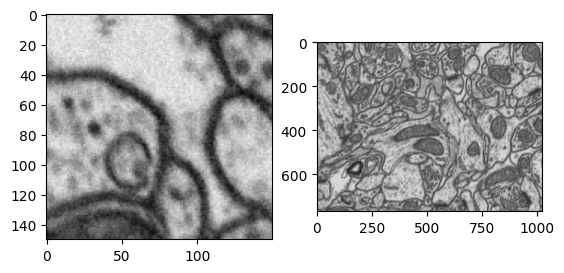

In [13]:
plt.subplot(121)
plt.imshow(data_augmentation(sample_image),cmap='gray')
plt.subplot(122)
plt.imshow(sample_image,cmap='gray')
plt.show()


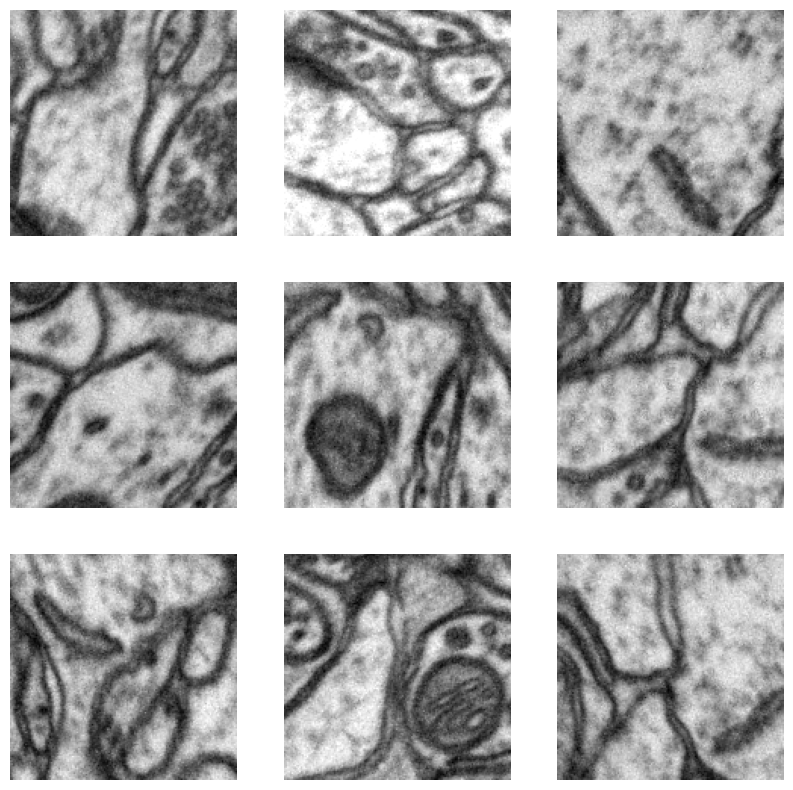

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(sample_image)
  plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image,cmap='gray')
  plt.axis("off")

In [15]:
type(sample_image)

tensorflow.python.framework.ops.EagerTensor

numpy.ndarray

In [16]:
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset,axis=3)

In [17]:
mask_dataset.shape[0]

100

In [18]:
type(image_dataset)

numpy.ndarray

Using tf.image for preprocessing images

In [19]:
def resize_and_rescale(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image

In [38]:
def augment(image_label, seed):
  print("inside augment and seed is",seed)
  image, label = image_label

  image = resize_and_rescale(image)
  label = resize_and_rescale(label)

  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  label = tf.image.resize_with_crop_or_pad(label, IMG_SIZE + 6, IMG_SIZE + 6)

  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]

  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  
  label = tf.image.stateless_random_crop(
      label, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  
  image = tf.clip_by_value(image, 0, 1)

  return image, label

In [42]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [57]:
rng.make_seeds(2)[0]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([-2863979078744183651,  6757674337120123255], dtype=int64)>

In [22]:
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

In [26]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [30]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [39]:
train_ds = (
    train_dataset
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

inside augment


In [75]:
def plot_batch_sizes(ds):
  batch_sizes = [batch[0].shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

In [69]:
batched_dataset = train_dataset.batch(30)
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 768, 1024, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 768, 1024, 1), dtype=tf.uint8, name=None))>

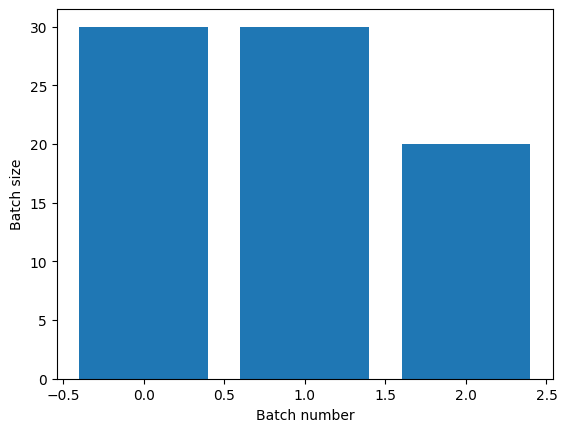

In [76]:
plot_batch_sizes(batched_dataset)

In [91]:
second = train_dataset.batch(30).repeat(2)

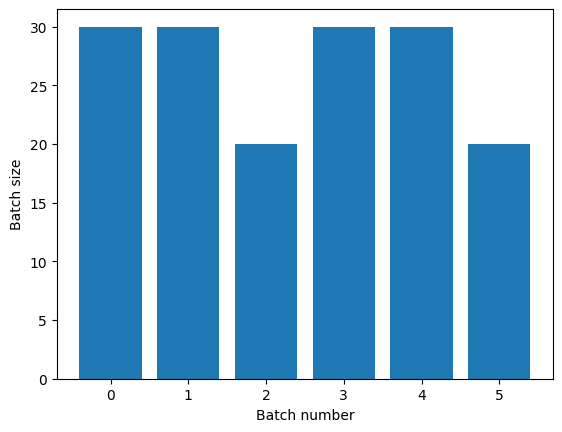

In [92]:
plot_batch_sizes(second)

In [29]:
image_dataset.shape

(100, 768, 1024, 1)

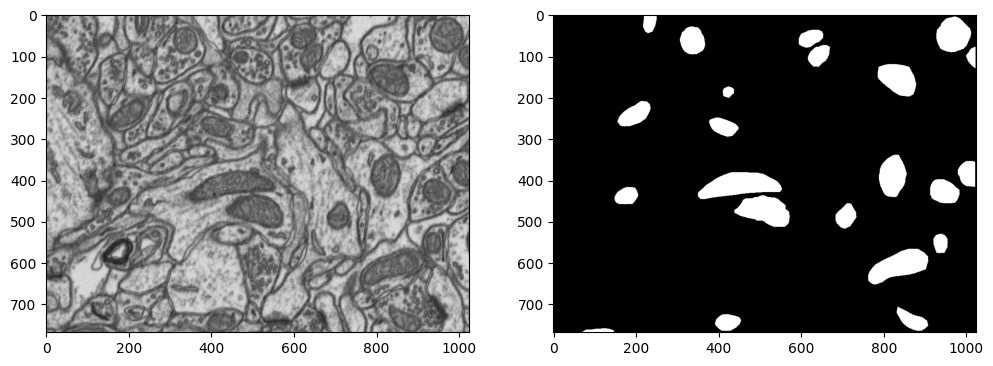

In [15]:
random_index = random.randint(0,image_dataset.shape[0])
random_image = images[random_index]
random_mask = masks[random_index]
display_image(random_image,random_mask)

In [41]:
image_dataset[0].shape

(768, 1024, 1)